In [31]:
import numpy as np 
import matplotlib.pyplot as plt
import skimage.filters.rank as skr 

from skimage.morphology import opening , disk ,closing
from skimage.filters import rank, gaussian 
from skimage.feature import peak_local_max
from skimage.measure import label 
from skimage.segmentation import watershed, mark_boundaries
from skimage.io import imread, imshow


brain = (255*imread('mri_brain.jpg', as_gray=True)).astype('uint8')
plt.gray()

def otsu_threshold(im):
    h,_ = np.histogram(im.flatten(), bins=np.arange(257))
    v= np.arange(256)
    best_sep = 0
    best_t = 0
    
    for t in range(1,255):
        w0 = h[:t].sum()
        w1 = h[t:].sum()

        m0=(v[:t]*h[:t]).sum()/w0
        m1=(v[t:]*h[t:]).sum()/w1

        s0=(h[:t] * (v[:t]-m0)**2).sum()/w0
        s1=(h[t:] * (v[t:]-m1)**2).sum()/w1

        sw= w0*s0 +w1*s1
        sb= w0*w1*(m1-m0)**2
        
        sep = sb/sw
        
        if sep>best_sep:
            best_sep = sep
            best_t= t
            
    return best_t 


<Figure size 432x288 with 0 Axes>

In [32]:
threshold=otsu_threshold(brain)

# apply first otsu thresholding 
image_threshold1 = brain.copy()
image_threshold1[image_threshold1<threshold] = 255


# apply second otsu thresholding 
threshold=otsu_threshold(image_threshold1)
image_threshold2 = image_threshold1.copy()
image_threshold2[image_threshold1<threshold] = 255


# transofrm to binary 
segmented_image = image_threshold2.copy()
segmented_image[segmented_image<255] = True
segmented_image[segmented_image==255] = False


# post processing 
opened_image =opening(segmented_image,disk(2))
closed_image =closing(opened_image,disk(2))

# compute the area 
area = int(closed_image.sum()*0.115)

<ipython-input-31-787c24dd2473>:26: RuntimeWarning: invalid value encountered in long_scalars
  m0=(v[:t]*h[:t]).sum()/w0


Text(0.5, 1.0, 'Closing, brain tumor is 371 cm²')

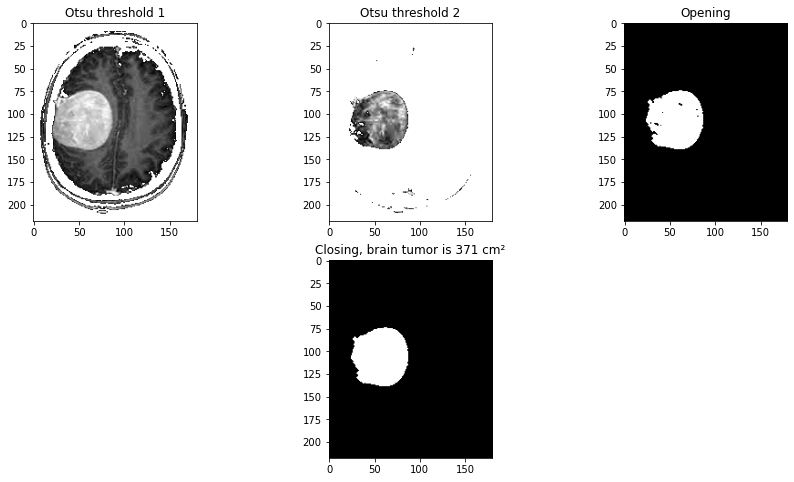

In [33]:
plt.figure(figsize=[15,8])
plt.subplot(2,3,1)
plt.imshow(image_threshold1)
plt.title('Otsu threshold 1')

plt.subplot(2,3,2)
plt.imshow(image_threshold2)
plt.title('Otsu threshold 2')

plt.subplot(2,3,3)
plt.imshow(opened_image)
plt.title('Opening')

plt.subplot(2,3,5)
plt.imshow(closed_image)
plt.title("Closing, brain tumor is {} cm²".format(area))

In [34]:

coords =np.array([[100 , 50],[100 , 150]])# since the region is know, the marker is set manually 

smoothed_image =skr.median(brain, disk(2))

grad_image = skr.gradient(smoothed_image,disk(1))

# extract labels
markers = np.zeros(grad_image.shape)
i=1
for row, col in coords : 
    markers[row, col]= i
    i+=1
    
# apply watershed 
ws = watershed(grad_image, markers)
result = mark_boundaries(brain,ws)
area =int((ws==1).sum()*0.115)

Text(0.5, 1.0, 'The brain tumor is 404 cm²')

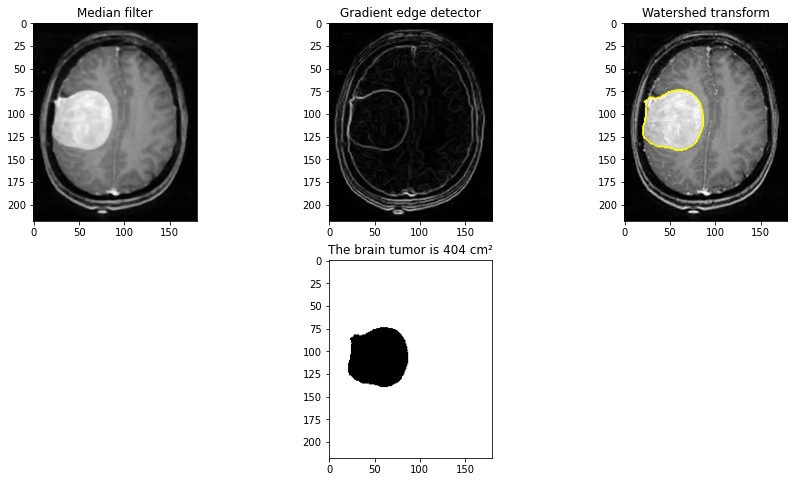

In [35]:
plt.figure(figsize=[15,8])
plt.subplot(2,3,1)
plt.imshow(smoothed_image)
plt.title('Median filter')


plt.subplot(2,3,2)
plt.imshow(grad_image)
plt.title('Gradient edge detector')


plt.subplot(2,3,3)
plt.imshow(result)
plt.title('Watershed transform')

plt.subplot(2,3,5)
plt.imshow(ws)
plt.title("The brain tumor is {} cm²".format(area))